In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import glob
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')
mpl.rcParams['savefig.dpi'] = 128
mpl.rcParams['figure.dpi'] = 128
# Plot size to 14" x 7"
mpl.rc('figure', figsize = (14, 7))
# Font size to 14
mpl.rc('font', size = 14)
# Do not display top and right frame lines
mpl.rc('axes.spines', top = False, right = False)
# Remove grid lines
mpl.rc('axes', grid = False)
# Set backgound color to white
mpl.rc('axes', facecolor = 'white')

In [2]:
# read whole year data
allFiles = glob.glob("data/*/*.csv")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0,encoding="utf-8")
    list_.append(df)
df = pd.concat(list_)

df.shape

(300285, 49)

In [3]:
df.drop_duplicates(inplace=True)
df.shape

(274129, 49)

In [4]:
def transform_cols(df):
    df.columns = map(str.lower, df.columns)
    df.columns = df.columns.str.replace('_', ' ')
    return df

In [5]:
df = transform_cols(df)

In [6]:
selected_features = ['classification','enquired',
                     'loan amount','loan reason','property use']
# selected_features = ['marketing code','enquired',
#                      'loan amount','loan reason','property use']
# selected_features = ['classification','enquired']
target = 'enquiry status';
whole_set = selected_features + [target]

df = df[whole_set]

In [7]:
df = df[~df[target].isin(['In Progress','Just Received','On Hold'])]
df.shape

(269530, 6)

In [8]:
def clearnLoanAmount(df): 
    invalid_columns= ['500001-$1000000',
                  '300001-$500000',
                  '0-$300000',
                  '250000 - 300000',
                  '250000-350000',
                  '2600 monthly',
                  'not_sure',
                  '1000,001+',
                 '9999-',
                  'I50000',
                  '1.5 M',
                  '1000001+',
                  '9999-',
                  '80-90k']
    if 'loan amount' in df.columns: 
        df['loan amount'].fillna(0,inplace=True)
        # convert to string to do replacement
        df['loan amount'] = df['loan amount'].astype("str")
        df['loan amount'] = df['loan amount'].str.replace(",","")
        df = df[~df['loan amount'].isin(invalid_columns)]
    return df

In [9]:
df = clearnLoanAmount(df)

In [10]:
df.shape

(268768, 6)

In [11]:
df['loan reason'].fillna('Other Loan Reason',inplace=True)

In [12]:
df['loan reason'].value_counts()

First HomeBuyer                                           116638
Buying Again                                               84404
Refinance                                                  25552
Other Loan Reason                                          22786
Buying Again,Refinance                                     10072
Refinance With Cash Out                                     6837
Buying Again,Refinance With Cash Out                         721
Refinance,Refinance With Cash Out                            646
First HomeBuyer,Refinance                                    385
First HomeBuyer,Buying Again                                 278
Loan Topup                                                   230
Buying Again,Refinance,Refinance With Cash Out                59
First HomeBuyer,Refinance With Cash Out                       32
Refinance,Loan Topup                                          29
Refinance,Other Loan Reason                                   23
Buying Again,Other Loan R

In [13]:
# df.loc[df['loan reason'].str.contains('First HomeBuyer'),'loan reason'] = 'First HomeBuyer'
# df.loc[df['loan reason'].str.contains('Buying Again'),'loan reason'] = 'Buying Again'
# df.loc[df['loan reason'].str.contains('Refinance'),'loan reason'] = 'Refinance'

df['loan reason'] = df['loan reason'].apply(lambda x: 'First HomeBuyer' if 'First HomeBuyer' in x else x)
df['loan reason'] = df['loan reason'].apply(lambda x: 'Buying Again' if 'Buying Again' in x else x)
df['loan reason'] = df['loan reason'].apply(lambda x: 'Refinance' if 'Refinance' in x else x)

In [14]:
df['loan reason'].value_counts()

First HomeBuyer      117368
Buying Again          95291
Refinance             33093
Other Loan Reason     22786
Loan Topup              230
Name: loan reason, dtype: int64

In [15]:
df['property use'].fillna('Other',inplace=True)

In [16]:
df['property use'].value_counts()

Residence                     175139
Other                          56386
Investment                     26698
Residence,Investment           10253
Residence,Other                  214
Investment,Other                  45
Residence,Investment,Other        33
Name: property use, dtype: int64

In [17]:
df['property use'] = df['property use'].apply(lambda x: 'Residence' if 'Residence' in x else x)
df['property use'] = df['property use'].apply(lambda x: 'Investment' if 'Investment' in x else x)

In [18]:
df['property use'].value_counts()

Residence     185639
Other          56386
Investment     26743
Name: property use, dtype: int64

In [19]:
df['classification'].fillna('None',inplace=True)

In [20]:
df['classification'].value_counts()

Domain                         47775
Google AdWords                 26835
Direct                         25516
Coregistration                 21864
REA                            19767
Alternative Media              19131
Affiliate                      17338
None                           14050
Omnilead                       12845
Home Sales                      8089
All Homes                       7678
Partners                        5800
First Home Buyers               5516
Domain Campaigns                5171
Phone                           4731
Email eChoice Database          4357
Finder                          3971
Domain Internal CBA Program     3620
Domain Campaigns CPA            1975
Domain Competitions             1791
External Email                  1275
Folio                           1173
Dynamic Home Loans              1093
Retention                        901
Refinancing AdWords              893
Portals                          775
Portal Campaigns                 735
M

In [21]:
for _ in df.columns:
    print("The number of null values in: {} == {}".format(_, df[_].isnull().sum()))

The number of null values in: classification == 0
The number of null values in: enquired == 0
The number of null values in: loan amount == 0
The number of null values in: loan reason == 0
The number of null values in: property use == 0
The number of null values in: enquiry status == 0


In [22]:
df.dropna(axis=0, how='any', inplace=True)
df.shape

(268768, 6)

In [23]:
for _ in df.columns:
    print("The number of null values in:{} == {}".format(_, df[_].isnull().sum()))

The number of null values in:classification == 0
The number of null values in:enquired == 0
The number of null values in:loan amount == 0
The number of null values in:loan reason == 0
The number of null values in:property use == 0
The number of null values in:enquiry status == 0


In [24]:
drop_values = ['QLD','victoria',"270-1176","VIC","2575b","6110r","2150s"]
if 'post code' in df.columns: 
    df = df[~df['post code'].isin(drop_values)]

In [25]:
def transform(df): 
    if 'loan amount' in df.columns: 
        df['loan amount'] = df['loan amount'].astype('float')
        
    if 'enquired' in df.columns: 
        df['enquired'] = pd.DatetimeIndex(df['enquired'])
        df['year'] = df['enquired'].dt.year
        df['month'] = df['enquired'].dt.month
        df['day'] = df['enquired'].dt.day
        df['hour'] = df['enquired'].dt.hour
        df['weekday'] = df['enquired'].dt.dayofweek
    
    if 'post code' in df.columns: 
        df['post code'] = df['post code'].astype('int')
    
    if 'enquired'in df.columns:
        df.drop(['enquired'], axis = 1, inplace = True)
        
    
    df.apply(lambda x: x.astype(str).str.lower())

In [26]:
transform(df)

In [27]:
if 'year' in df.columns:
    df = df[~(df['year'] < 2009)]
    df[(df['year'] < 2009)]

In [28]:
df.reset_index(drop=True,inplace=True)

In [29]:
test = df[df['enquiry status'] == 'Rejected']
test.shape

(218370, 10)

In [30]:
test = df[df['enquiry status'] == 'Accepted']
test.shape

(50269, 10)

In [31]:
test['year'].value_counts()

2015    7610
2010    7001
2014    6841
2016    6374
2013    6357
2011    6037
2012    5194
2017    4452
2009     403
Name: year, dtype: int64

In [32]:
df.dtypes

classification     object
loan amount       float64
loan reason        object
property use       object
enquiry status     object
year                int64
month               int64
day                 int64
hour                int64
weekday             int64
dtype: object

In [33]:
df['classification'].value_counts()

Domain                         47775
Google AdWords                 26835
Direct                         25484
Coregistration                 21864
REA                            19760
Alternative Media              19131
Affiliate                      17338
None                           13997
Omnilead                       12845
Home Sales                      8089
All Homes                       7678
Partners                        5798
First Home Buyers               5516
Domain Campaigns                5171
Phone                           4725
Email eChoice Database          4357
Finder                          3971
Domain Internal CBA Program     3620
Domain Campaigns CPA            1975
Domain Competitions             1791
External Email                  1275
Folio                           1173
Dynamic Home Loans              1093
Retention                        901
Refinancing AdWords              893
Portals                          775
Portal Campaigns                 735
R

In [34]:
# df = df[~df['marketing code'].isin(rows_to_drop)]
# df.shape
# df.drop_duplicates()
# duplicates = df[df.duplicated()]
# duplicates[duplicates['enquiry status'] == 'Accepted']

In [35]:
hist = test.groupby(['year']).size().reset_index(name="counts")

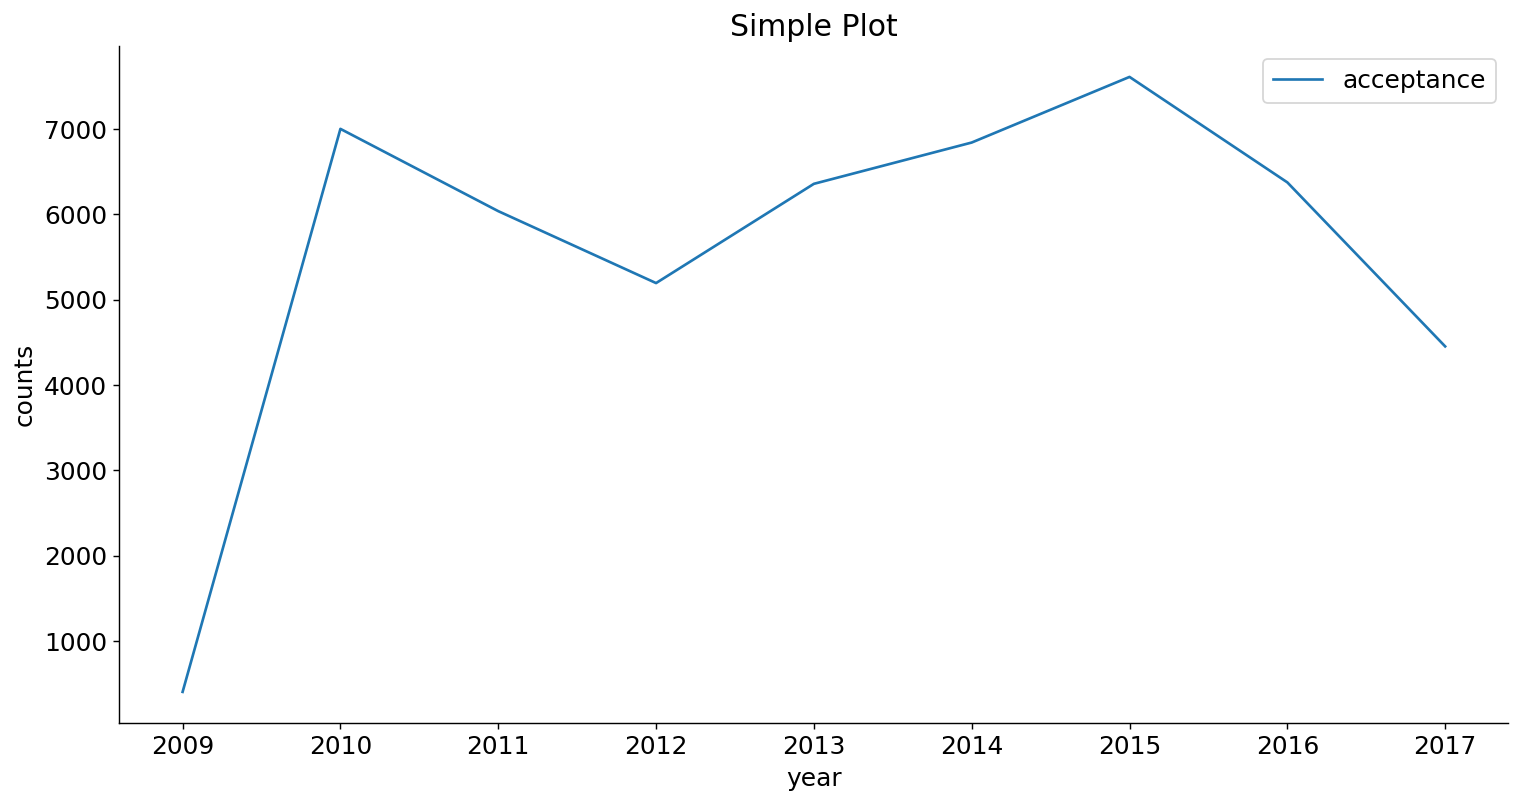

In [36]:
fig = plt.figure()
plt.plot(hist["year"], hist["counts"], label='acceptance')
plt.xlabel('year')
plt.ylabel('counts')
plt.title("Simple Plot")
plt.legend()
plt.show()

In [37]:
df.shape

(268639, 10)

In [38]:
data_frame = df.drop('year', axis = 1) 
data_frame['loan amount'] = data_frame['loan amount'].astype(int)

In [39]:
# df.to_csv("2014-2017.csv",index=False)

In [40]:
# data_frame.to_csv("2009-2017.csv",index=False)

,loan amount,month,day,hour,weekday
loan amount,1.000000,-0.003877,-0.002427,0.001795,-0.000779
month,-0.003877,1.000000,0.019274,-0.020556,0.000757
day,-0.002427,0.019274,1.000000,-0.000623,0.021167
hour,0.001795,-0.020556,-0.000623,1.000000,-0.028950
weekday,-0.000779,0.000757,0.021167,-0.028950,1.000000


Because marketing code is variable that has changed in so many years, so it has much less impact on the result compare to other features